In [1]:
import tensorflow as tf
import tensorflow.contrib.tensorrt as trt
import tensorflow.keras as tfk
import random
import os
import pathlib
from tensorflow.keras.models import load_model
from tensorflow.compat.v1.graph_util import convert_variables_to_constants
from tensorflow.python.platform import gfile
from tensorflow.python.tools import freeze_graph

In [2]:
base_path = os.getcwd()
keras_model_pfad = "keras_model_0.h5"
tf_model_pfad = os.path.join(base_path,'../Models/tensorflow/Tensor_')
fr_graph_tf_model = tf_model_pfad + "frozen_model_tf.pb"
fr_graph_trt_model =os.path.join(base_path,'../Models/RT-Model/frozen_model_trt.pb')

### Keras zu Tensorflow-Model

In [3]:
 """
diese Funktion wird ein Keras-Model in ein Tensor-Model
Umwandeln
"""
""" da die Batchnormalisation-Parameter im Keras
als trainable parameter gespeichert sind, mussen wird diese als
non_trainable zurücksetzen
"""
tf.keras.backend.set_learning_phase(0)

print("Keras-Model wird hochgeladen!")
try:
    model = load_model(keras_model_pfad)
except FileNotFoundError:
    print("Kein .h5-Datei wurde gefunden!")
    exit()
# get input und output des models for tensorflow improvement
input_model = model.inputs[0]
print(input_model)
output_model = model.outputs[0]

print("Umwandlung vom Keras zu Tensor-Model..")
# model.summary()
# [print(node.op.name) for node in model.outputs]
saver = tf.train.Saver()
# keras session wird als tf- Session gelesen!
sess = tf.keras.backend.get_session()
# die Graph der Tf-Session wird gespeichert
save_path = saver.save(sess, tf_model_pfad)
tf.keras.backend.clear_session()
print("Umgewandelt und gespeichert!")

Keras-Model wird hochgeladen!
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Tensor("conv2d_input:0", shape=(?, 48, 48, 3), dtype=float32)
Umwandlung vom Keras zu Tensor-Model..
Umgewandelt und gespeichert!


### Convert Tf-Model zu tf-Frozen-Model

In [4]:
"""
 das aus Keras-Model Generierte Tensort-Model(oder ein normales
 Tensor-Model) wird hochgeladen
 und in frozen Graph umgewandelt
 input : tensor-Model
 ouput : frozen graph .pd
"""
# set the memory fraction eg. 0.2 meaning tf use 20% of gpu and
# the will bei Trt
gpu_option = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_option)) as sess:
    # import of meta graph fo tensorflow model
    path_meta_file = tf_model_pfad + ".meta"
    saver = tf.train.import_meta_graph(path_meta_file)
    # print(graph)
    # exit()
    # restore the weights to the meta graph
    saver.restore(sess, tf_model_pfad)

    # specify the tensor output of the model
    output_models = [n.name for
                     n in tf.get_default_graph().as_graph_def().node
                     if "dense_1/Softmax" in n.name]
    print(output_models)
    # print(output_models)
    # exit()
    # convert to frozen model
    print("Frozen model ergestellt!")
    frozen_graph = convert_variables_to_constants(sess,
                                                  tf.get_default_graph().as_graph_def(),
                                                  output_node_names=["dense_1/Softmax"])

    # save the frozen graph
    print("speichert!")
    with gfile.FastGFile(fr_graph_tf_model, "wb") as f:
        f.write(frozen_graph.SerializeToString())
    print("Frozen model wurde gespeichert!")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/kamgo/Donnees/Master_projekt/TensorRT/Verkehrszeichenerkennung/jupyter/../Models/tensorflow/Tensor_
['dense_1/Softmax']
Frozen model ergestellt!
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 16 variables.
INFO:tensorflow:Converted 16 variables to const ops.
speichert!
Instructions for updating:
Use tf.gfile.GFile.
Frozen model wurde gespeichert!


### Tensorflow-Frozen zu TensorRT-Model

In [5]:
# Erstellung von TRT-Frozen-Model
## read tensorflozen-Graph
with tf.gfile.GFile(fr_graph_tf_model, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
trt_graph = trt.create_inference_graph(input_graph_def=graph_def,outputs=["dense_1/Softmax"], max_batch_size=2,max_workspace_size_bytes=2*(10**9), precision_mode="FP32")

# save Frozen-Graph von TensorRT
if not pathlib.Path(fr_graph_trt_model).exists():
    os.mknod(fr_graph_trt_model)
with gfile.FastGFile(fr_graph_trt_model, "wb") as f:
    f.write(trt_graph.SerializeToString())

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
INFO:tensorflow:Running against TensorRT version 0.0.0


##  Improve Model

gelesen wird: Zulässige Höchstgeschwindigkeit (20 km/h)
gelesen wird: Zulässige Höchstgeschwindigkeit (60 km/h)


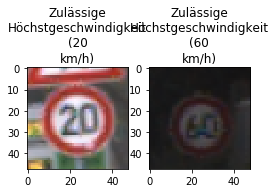

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import time
import numpy as np

IMG_SIZE = 48
input_node = "conv2d_input:0"
output_node = "dense_1/Softmax:0"
pfad_beschreibung = os.path.join(base_path,"../Daten/utils/Text_Beschreibung.csv")
classe_label = pd.read_csv(pfad_beschreibung)
classe_label = classe_label.set_index('ClassId').T.to_dict()

# Bilder werden einglesen im RGB-Format
img1 = cv2.imread("00000_00010.ppm", cv2.IMREAD_UNCHANGED)
print("gelesen wird:",classe_label[0]['SignName'])
img2 = cv2.imread("00000_00006.ppm", cv2.IMREAD_UNCHANGED)
print("gelesen wird:",classe_label[3]['SignName'])

image1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

#image preporcessing
image1 = cv2.resize(image1, (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA) 
image2 = cv2.resize(image2, (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA) 

images = [image1, image2]
labels_classes = [0, 3]

# show image
fig=plt.figure(figsize=(4, 4))
columns = 2
rows = 1
count = 1
for real_image in zip(images, labels_classes):
    fig.add_subplot(rows, columns,count)
    count +=1
    real_label = classe_label[real_image[1]]['SignName']
    real_label = real_label.replace(" ", "\n")
    plt.title(real_label)
    plt.imshow(real_image[0])       
plt.show()

In [7]:
def perform_model(path_frozen_graph, input_node, output_node, input_img):
    """
    Diese funktion wird dafür helfen, irgenwelches Model(Tensorflow/TensorRt)
    anzuwenden
    """
    gpu_option = tf.GPUOptions(per_process_gpu_memory_fraction=0.50)
    frozen_graph = tf.Graph()
    with frozen_graph.as_default():
        with tf.Session(config=tf.ConfigProto(gpu_options=gpu_option)) as sess:
            print("der Graph wird gelesen!")
            with tf.gfile.GFile(fr_graph_tf_model, "rb") as f:
                frozen_graph = tf.GraphDef()
                frozen_graph.ParseFromString(f.read())
            print("der wurde gelesen!")

            # Auswahl von input und output
            tf.import_graph_def(frozen_graph, name='')
            input_tensor = sess.graph.get_tensor_by_name(input_node)
            output_tensor = sess.graph.get_tensor_by_name(output_node)

            total_time = 0
            n_time_inference = 50
            input_img = input_img.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
            out_pred = sess.run(output_tensor,
                                feed_dict={input_tensor: input_img})

            for i in range(n_time_inference):
                t1 = time.time()
                out_pred = sess.run(output_tensor,
                                    feed_dict={input_tensor: input_img})
                t2 = time.time()
                delta_time = t2 - t1
                total_time += delta_time
                print("gebrauchte Zeit - " + str(i) + ": ", delta_time)
            print("mittelre Zeit: {}".format(total_time/n_time_inference))
            mittelre_zeit = total_time/n_time_inference
    return out_pred, mittelre_zeit


### Frozen -Graph Tensorflow

der Graph wird gelesen!
der wurde gelesen!
gebrauchte Zeit - 0:  0.002963542938232422
gebrauchte Zeit - 1:  0.0031890869140625
gebrauchte Zeit - 2:  0.003536701202392578
gebrauchte Zeit - 3:  0.0030455589294433594
gebrauchte Zeit - 4:  0.003216266632080078
gebrauchte Zeit - 5:  0.004129171371459961
gebrauchte Zeit - 6:  0.003484010696411133
gebrauchte Zeit - 7:  0.0032804012298583984
gebrauchte Zeit - 8:  0.0030732154846191406
gebrauchte Zeit - 9:  0.0033524036407470703
gebrauchte Zeit - 10:  0.003301382064819336
gebrauchte Zeit - 11:  0.0033202171325683594
gebrauchte Zeit - 12:  0.0030715465545654297
gebrauchte Zeit - 13:  0.003167867660522461
gebrauchte Zeit - 14:  0.003215312957763672
gebrauchte Zeit - 15:  0.0038917064666748047
gebrauchte Zeit - 16:  0.0046923160552978516
gebrauchte Zeit - 17:  0.0027017593383789062
gebrauchte Zeit - 18:  0.003120899200439453
gebrauchte Zeit - 19:  0.002910614013671875
gebrauchte Zeit - 20:  0.0071337223052978516
gebrauchte Zeit - 21:  0.0041763782

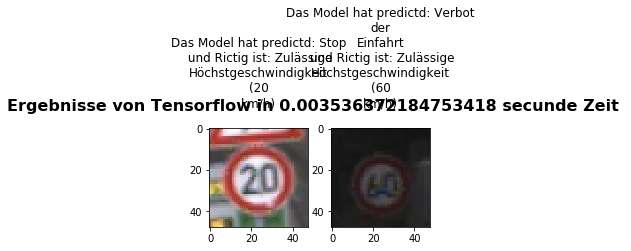

In [8]:
prediction_classes = []
sum_zeit=0
for image in images:
    prediction, zeit = perform_model(fr_graph_tf_model,
                                     input_node,
                                     output_node,
                                     image)
    prediction_classes.append(prediction)
    sum_zeit += zeit

# show image
fig=plt.figure(figsize=(4, 4))
columns = 2
rows = 2
count = 1
for image, label_class,predicted_class in zip(images, labels_classes, prediction_classes):
    fig.add_subplot(rows, columns,count)
    count +=1
    real_label = classe_label[label_class]['SignName']
    real_label = real_label.replace(" ", "\n")
    predicted_label = classe_label[np.argmax(predicted_class[0])]['SignName']
    predicted_label = predicted_label.replace(" ", "\n")
    plt.title("Das Model hat predictd: {}\n und Rictig ist: {}\n".format(predicted_label, real_label))
    plt.imshow(image)
label = 'Ergebnisse von Tensorflow in {} secunde Zeit '.format(sum_zeit/len(images))
fig.suptitle(label, fontsize=16, fontweight="bold")
plt.show()

### tensorRT - Model

der Graph wird gelesen!
der wurde gelesen!
gebrauchte Zeit - 0:  0.0037724971771240234
gebrauchte Zeit - 1:  0.003446340560913086
gebrauchte Zeit - 2:  0.002907991409301758
gebrauchte Zeit - 3:  0.0031337738037109375
gebrauchte Zeit - 4:  0.0028128623962402344
gebrauchte Zeit - 5:  0.0029921531677246094
gebrauchte Zeit - 6:  0.003093719482421875
gebrauchte Zeit - 7:  0.0026650428771972656
gebrauchte Zeit - 8:  0.0030906200408935547
gebrauchte Zeit - 9:  0.0029735565185546875
gebrauchte Zeit - 10:  0.002949237823486328
gebrauchte Zeit - 11:  0.0030133724212646484
gebrauchte Zeit - 12:  0.0027968883514404297
gebrauchte Zeit - 13:  0.003187417984008789
gebrauchte Zeit - 14:  0.0031595230102539062
gebrauchte Zeit - 15:  0.003345966339111328
gebrauchte Zeit - 16:  0.0031960010528564453
gebrauchte Zeit - 17:  0.002930164337158203
gebrauchte Zeit - 18:  0.002805471420288086
gebrauchte Zeit - 19:  0.003237485885620117
gebrauchte Zeit - 20:  0.002472400665283203
gebrauchte Zeit - 21:  0.0029292

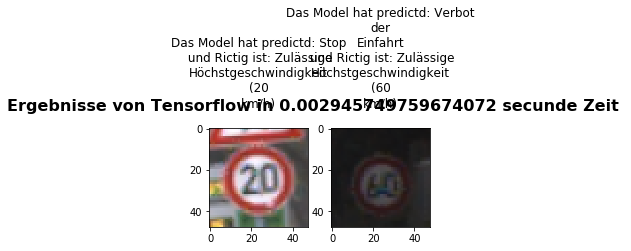

In [9]:
prediction_classes = []
sum_zeit=0
for image in images:
    prediction, zeit = perform_model(fr_graph_trt_model,
                                     input_node,
                                     output_node,
                                     image)
    prediction_classes.append(prediction)
    sum_zeit += zeit

# show image
fig=plt.figure(figsize=(4, 4))
columns = 2
rows = 2
count = 1
for image, label_class,predicted_class in zip(images, labels_classes, prediction_classes):
    fig.add_subplot(rows, columns,count)
    count +=1
    real_label = classe_label[label_class]['SignName']
    real_label = real_label.replace(" ", "\n")
    predicted_label = classe_label[np.argmax(predicted_class[0])]['SignName']
    predicted_label = predicted_label.replace(" ", "\n")
    plt.title("Das Model hat predictd: {}\n und Rictig ist: {}\n".format(predicted_label, real_label))
    plt.imshow(image)
label = 'Ergebnisse von Tensorflow in {} secunde Zeit '.format(sum_zeit/len(images))
fig.suptitle(label, fontsize=16, fontweight="bold")
plt.show()